In [1]:
%load_ext autoreload

In [93]:
%autoreload

import jax
import jax.numpy as jnp
import jax.random as random

from functools import partial
import matplotlib.pyplot as plt

from jax.example_libraries import optimizers
from jax.scipy.optimize import minimize
import jax.scipy.stats as stats

from tqdm.auto import tqdm

from gaul import vi
from gaul.utils.tree_utils import tree_zeros_like

plt.style.use(['fivethirtyeight', 'seaborn-dark'])

In [106]:
def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return mean + jnp.exp(log_std) * random.normal(rng, mean.shape)

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate a single point on a diagonal multivariate Gaussian.
    return jnp.sum(jax.vmap(stats.norm.logpdf)(x, mean, jnp.exp(log_std)))

def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = jax.vmap(partial(elbo, logprob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *params))

In [3]:
@partial(jax.jit, static_argnums=(0, 1, 2, 4))
def _mesh_eval(func, x_limits, y_limits, params, num_ticks):
    # Evaluate func on a 2D grid defined by x_limits and y_limits.
    x = jnp.linspace(*x_limits, num=num_ticks)
    y = jnp.linspace(*y_limits, num=num_ticks)
    X, Y = jnp.meshgrid(x, y)
    xy_vec = jnp.stack([X.ravel(), Y.ravel()]).T
    zs = jax.vmap(func, in_axes=(0, None))(xy_vec, params)
    return X, Y, zs.reshape(X.shape)

def mesh_eval(func, x_limits, y_limits, params, num_ticks=101):
    return _mesh_eval(func, x_limits, y_limits, params, num_ticks)

In [4]:
@jax.jit
def log_density(params):
    rng = random.PRNGKey(1)
    m = random.normal(rng, shape=(2,))
    c = random.normal(rng, shape=(2, 2))
    return stats.multivariate_normal.logpdf(params, m, c @ c.T)

In [132]:
def objective(params, t):
    rng = random.PRNGKey(t)
    return -batch_elbo(log_density, rng, params, num_samples)

In [133]:
# Set up optimizer.
D = 2
init_mean = jnp.zeros(D)
init_std  = jnp.ones(D)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.adam(step_size=0.2)
opt_state = opt_init(init_params)

def update(opt_state, i):
    params = get_params(opt_state)
    gradient = jax.grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

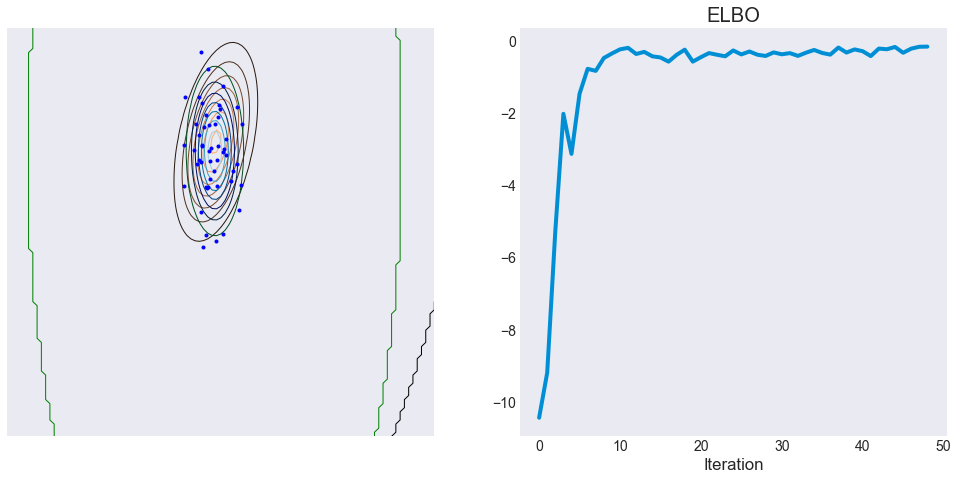

  0%|          | 0/50 [00:00<?, ?it/s]

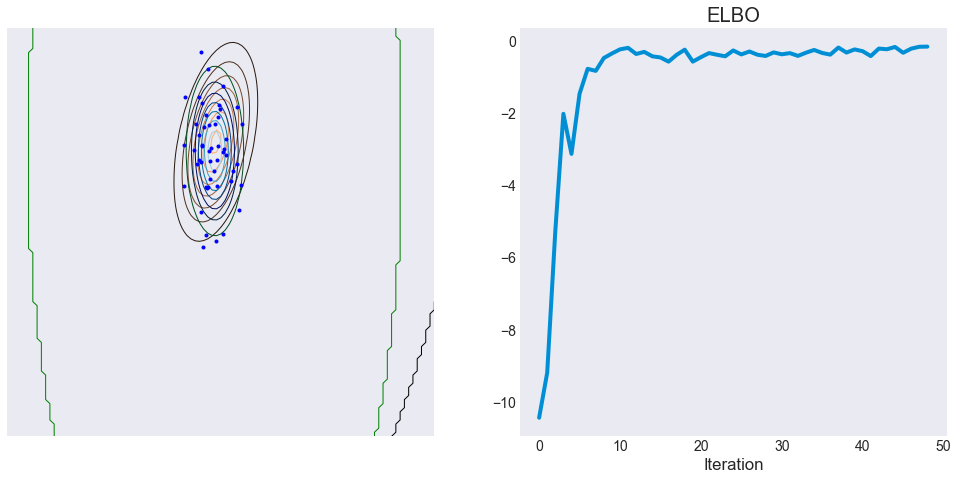

In [134]:
num_samples=50

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hfig = display(fig, display_id=True)

x_limits = (-5, 5)
y_limits = (-5, 5)
target_dist = lambda x, _: jnp.exp(log_density(x))
approx_dist = lambda x, params: jnp.exp(diag_gaussian_logpdf(x, *params))

elbos = []

def callback(params, t):
    
    el = objective(params, t)
    
    ax.clear()
    ax2.clear()

    X, Y, Z = mesh_eval(target_dist, x_limits, y_limits, 1)
    ax.contour(X, Y, Z, cmap='copper', linewidths=1)
    X, Y, Z = mesh_eval(approx_dist, x_limits, y_limits, params)
    ax.contour(X, Y, Z, cmap='ocean', linewidths=1)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_yticks([])
    ax.set_xticks([])
    ax2.set_title('ELBO')
    ax2.set_xlabel('Iteration')

    rngs = random.split(random.PRNGKey(t), num_samples)
    samples = jax.vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)
    # samples = jax.vmap(random.multivariate_normal, in_axes=(0, None, None))(rngs, params[0], params[1] @ params[1].T)
    ax.plot(samples[:, 0], samples[:, 1], 'b.')
    ax2.plot(elbos)
    
    fig.canvas.draw()
    hfig.update(fig)

    return -el

for t in (pbar := tqdm(range(50))):
    opt_state = update(opt_state, t)
    params = get_params(opt_state)
    el = callback(params, t)
    elbos.append(el)
    pbar.set_description(f"ELBO: {el}")

In [91]:
import operator

@jax.jit
def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return jax.tree_util.tree_map(
        lambda m, ls: random.normal(rng, m.shape) * jnp.exp(ls) + m, mean, log_std
    )

@jax.jit
def diag_gaussian_logpdf(x, mean, log_std) -> float:
    # Evaluate a single point on a diagonal multivariate Gaussian.
    logpdfs = jax.tree_util.tree_map(
        lambda x, m, ls: stats.norm.logpdf(x, m, jnp.exp(ls)), x, mean, log_std
    )
    return jax.tree_util.tree_reduce(operator.add, logpdfs, 0.0)
    # return jnp.sum(jax.vmap(stats.norm.logpdf)(x, mean, jnp.exp(log_std)))

@partial(jax.jit, static_argnums=(0,))
def elbo(ln_prob, rng, mean, log_std) -> float:
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return ln_prob(sample) - diag_gaussian_logpdf(sample, mean, log_std)


@partial(jax.jit, static_argnums=(0,))
def batch_elbo(ln_prob, rng, vi_params, nsamples: int) -> float:
    # Average over a batch of random samples.
    rngs = random.split(rng, nsamples)
    vectorized_elbo = jax.vmap(partial(elbo, ln_prob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *vi_params))


In [20]:
rng = random.PRNGKey(0)

In [26]:
beta0 = 0.5
beta1 = -0.4
sigma = 1.6
n = 50

key = jax.random.PRNGKey(0)
xkey, ykey = jax.random.split(key)

x = jax.random.uniform(xkey, shape=(n,)) * 10.
x = jnp.sort(x)
ymean = beta0 + beta1 * x
y = jax.random.normal(ykey, shape=(n,)) * sigma + ymean

data = dict(
    x=x,
    y=y,
)

In [29]:
params = dict(beta0=jnp.zeros(1), beta1=jnp.zeros(1), sigma=jnp.zeros(1))
means = tree_zeros_like(params)
logstds = tree_zeros_like(params)

In [74]:
@jax.jit
def ln_posterior(params, data):
    target = 0
    target += stats.norm.logpdf(params['beta0'], 0., 2.)
    target += stats.norm.logpdf(params['beta1'], 0., 2.)
    target += stats.expon.logpdf(jnp.exp(params['sigma']), scale=1.)
    ymean = params['beta0'] + params['beta1'] * data['x']
    target += stats.norm.logpdf(data['y'], ymean, jnp.exp(params['sigma'])).sum()
    return target.sum()


In [86]:
sample = diag_gaussian_sample(rng, means, logstds)
diag_gaussian_logpdf(sample, means, logstds)

DeviceArray([-2.820372], dtype=float32)

In [92]:
%%time
batch_elbo(lnp, rng, (means, logstds), 100)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.
While tracing the function batch_elbo at /tmp/ipykernel_2619247/3890462418.py:26 for jit, this concrete value was not available in Python because it depends on the value of the argument passed at flattened position 7.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [94]:
samples = vi.sample(ln_posterior, params, nsteps=5000, data=data)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [95]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

In [96]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

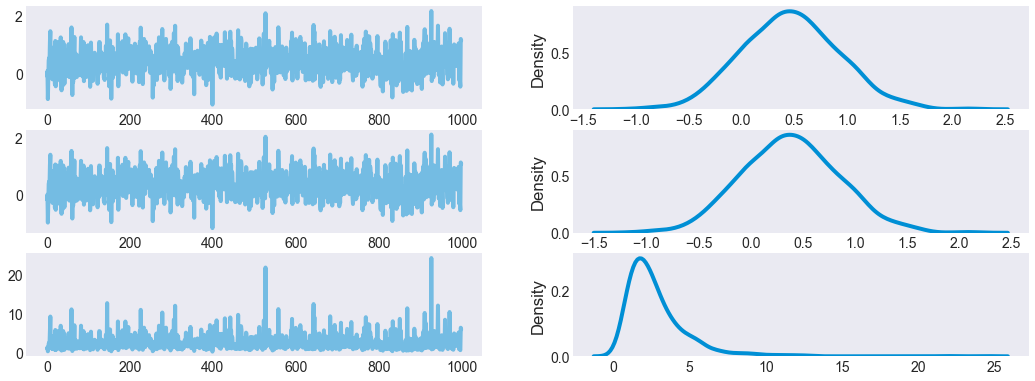

In [97]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))

ax[0,0].plot(samples['beta0'], alpha=0.5)
ax[1,0].plot(samples['beta1'], alpha=0.5)
ax[2,0].plot(jnp.exp(samples['sigma']), alpha=0.5)
sns.kdeplot(samples['beta0'], ax=ax[0,1])
sns.kdeplot(samples['beta1'], ax=ax[1,1])
sns.kdeplot(jnp.exp(samples['sigma']), ax=ax[2,1])

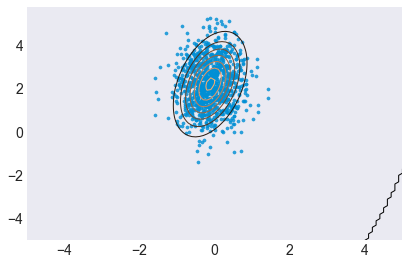

In [8]:
x_limits = (-5, 5)
y_limits = (-5, 5)
target_dist = lambda x, _: jnp.exp(log_density(x))
X, Y, Z = mesh_eval(target_dist, x_limits, y_limits, 1)
plt.contour(X, Y, Z, cmap='copper', linewidths=1)
plt.scatter(samples[:,0], samples[:,1], s=10, alpha=0.8)

In [146]:
sol = minimize(lambda x: -log_density(x), jnp.ones(2), method='l-bfgs-experimental-do-not-rely-on-this')
lplmean = sol.x
lplcov = jnp.linalg.inv(-jax.hessian(log_density)(lplmean))
lpldist = lambda x, params: jnp.exp(stats.multivariate_normal.logpdf(x, *params))

(-1.0, 5.0)

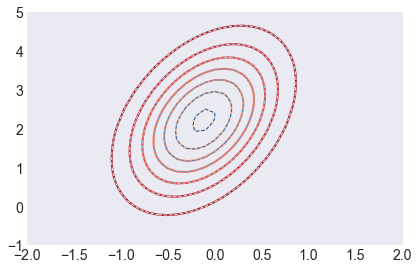

In [147]:
X, Y, Z = mesh_eval(lambda x, _: -jnp.exp(log_density(x)), x_limits, y_limits, 1)
plt.contour(X, Y, Z, cmap='Reds', linewidths=2)
X, Y, Z = mesh_eval(lpldist, x_limits, y_limits, [lplmean, lplcov])
plt.contour(X, Y, Z, cmap='Blues', linewidths=1, linestyles='--', dashes=(7, 7))
plt.xlim(-2, 2)
plt.ylim(-1, 5)